In [4]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from tensorflow.keras.models import load_model

### Functions for the pipeline:

In [5]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [112]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU with better precision
    return round(inter_area / union_area, 6) if union_area > 0 else 0

# Example: calculating IoU for two bounding boxes
box1 = (50, 50, 150, 150)
box2 = (100, 100, 200, 200)

iou_value = calculate_iou(box1, box2)
print(f"IoU between the boxes: {iou_value}")


IoU between the boxes: 0.142857


In [38]:
input_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset"
output_path = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\kaggle challenge\Kaggle Dataset\output"
patch_size = 256
example_file_name = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 5\michal_232079_unet_model_v3_256px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1})

# Define the example image for visualizations
example_id = "10"  # The ID of the image you want visualized (e.g., "test_image_1.png" -> ID = "1")


---

### Cropping the images

Processed: test_image_1.png | Cropped Shape: (2707, 2707)
Processed: test_image_10.png | Cropped Shape: (2778, 2778)
Processed: test_image_11.png | Cropped Shape: (2776, 2776)
Processed: test_image_12.png | Cropped Shape: (2788, 2788)
Processed: test_image_13.png | Cropped Shape: (2927, 2927)
Processed: test_image_14.png | Cropped Shape: (2785, 2785)
Processed: test_image_15.png | Cropped Shape: (2787, 2787)
Processed: test_image_16.png | Cropped Shape: (2789, 2789)
Processed: test_image_17.png | Cropped Shape: (2788, 2788)
Processed: test_image_18.png | Cropped Shape: (2788, 2788)
Processed: test_image_2.png | Cropped Shape: (2706, 2706)
Processed: test_image_3.png | Cropped Shape: (2706, 2706)
Processed: test_image_4.png | Cropped Shape: (2706, 2706)
Processed: test_image_5.png | Cropped Shape: (2706, 2706)
Processed: test_image_6.png | Cropped Shape: (2705, 2705)
Processed: test_image_7.png | Cropped Shape: (2706, 2706)
Processed: test_image_8.png | Cropped Shape: (2706, 2706)
Proce

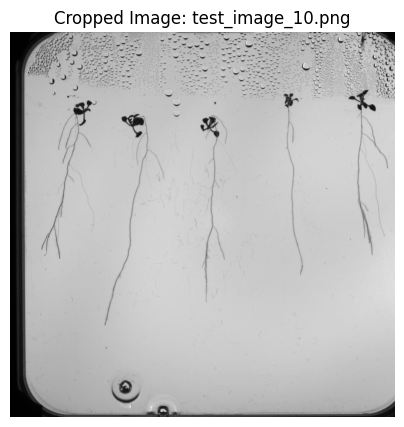

In [ ]:
def find_edges(line, threshold=70):
    """
    Finds the left and right edges in a 1D array based on a threshold value.
    """
    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

def format(image, initial_crop=100):
    """
    Crops an image to a square region using edge detection, with an initial horizontal crop.
    """
    # Step 1: Initial horizontal crop
    image = image[:, initial_crop:-initial_crop]  # Crop 100 pixels from left and right

    # Step 2: Horizontal and vertical slices for edge detection
    horizontal_line = image[image.shape[0] // 2, :]  # Middle row of the image
    vertical_line = image[:, image.shape[1] // 2]   # Middle column of the image
    
    # Step 3: Find edges
    left_x, right_x = find_edges(horizontal_line)
    top_y, bottom_y = find_edges(vertical_line)
    
    # Step 4: Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    
    # Step 5: Return slices for cropping
    return slice(top_y, bottom_y), slice(left_x, right_x)

def process_images(input_path, initial_crop=100):
    """
    Processes all images in a folder by cropping them based on detected edges.
    """
    cropped_images = {}  # Dictionary to store cropped images and their slices
    
    for file_name in os.listdir(input_path):
        file_path = os.path.join(input_path, file_name)
        
        # Ensure the file is an image
        if not (file_name.endswith(".png") or file_name.endswith(".jpg") or file_name.endswith(".jpeg")):
            continue
        
        # Load the image
        original_image = cv2.imread(file_path, 0)  # Load as grayscale

        # Crop the image using the format function
        crop_slices = format(original_image, initial_crop=initial_crop)
        cropped_image = original_image[crop_slices]
        
        # Save the cropped image and slices in the dictionary
        cropped_images[file_name] = {
            "cropped_image": cropped_image,
            "crop_slices": crop_slices
        }
        
        print(f"Processed: {file_name} | Cropped Shape: {cropped_image.shape}")
    
    return cropped_images

# Process images and visualize the specified example image
cropped_images = process_images(input_path, initial_crop=90)

# Visualize only the example image
example_file_name = f"test_image_{example_id}.png"  # Match the naming convention
if example_file_name in cropped_images:
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_images[example_file_name]["cropped_image"], cmap="gray")
    plt.title(f"Cropped Image: {example_file_name}")
    plt.axis("off")
    plt.show()



### Padding the images

Processed test_image_1.png: Original Shape = (2707, 2707), Padded Shape = (2816, 2816), Padding = (Top: 54, Bottom: 55, Left: 54, Right: 55)
Processed test_image_10.png: Original Shape = (2778, 2778), Padded Shape = (2816, 2816), Padding = (Top: 19, Bottom: 19, Left: 19, Right: 19)
Visualizing example image: test_image_10.png


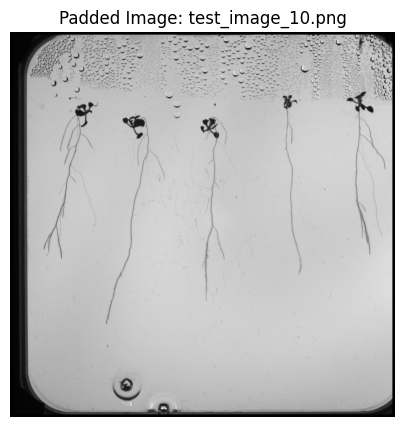

Processed test_image_11.png: Original Shape = (2776, 2776), Padded Shape = (2816, 2816), Padding = (Top: 20, Bottom: 20, Left: 20, Right: 20)
Processed test_image_12.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Processed test_image_13.png: Original Shape = (2927, 2927), Padded Shape = (3072, 3072), Padding = (Top: 72, Bottom: 73, Left: 72, Right: 73)
Processed test_image_14.png: Original Shape = (2785, 2785), Padded Shape = (2816, 2816), Padding = (Top: 15, Bottom: 16, Left: 15, Right: 16)
Processed test_image_15.png: Original Shape = (2787, 2787), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 15, Left: 14, Right: 15)
Processed test_image_16.png: Original Shape = (2789, 2789), Padded Shape = (2816, 2816), Padding = (Top: 13, Bottom: 14, Left: 13, Right: 14)
Processed test_image_17.png: Original Shape = (2788, 2788), Padded Shape = (2816, 2816), Padding = (Top: 14, Bottom: 14, Left: 14, Right: 14)
Proces

In [50]:
def padder_from_cropped_images(cropped_images, patch_size, example_id=None):
    """
    Adds padding to all cropped images to make their dimensions divisible by a specified patch size.
    Visualizes results for a specified example image ID.

    Parameters:
        cropped_images (dict): A dictionary with image names as keys and values containing:
            - "cropped_image": The cropped image as a NumPy array.
            - "crop_slices": The crop slices used to crop the original image.
        patch_size (int): The size of the patches the image should be divisible by.
        example_id (str): The ID of the image to visualize results for.

    Returns:
        dict: Updated dictionary with padded images and padding values added.
    """
    padded_images = {}

    for file_name, data in cropped_images.items():
        cropped_image = data["cropped_image"]  # Extract the cropped image

        # Get dimensions of the cropped image
        h, w = cropped_image.shape[:2]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = height_padding // 2
        bottom_padding = height_padding - top_padding

        left_padding = width_padding // 2
        right_padding = width_padding - left_padding

        # Add padding using cv2.copyMakeBorder
        padded_image = cv2.copyMakeBorder(
            cropped_image,
            top_padding,
            bottom_padding,
            left_padding,
            right_padding,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0]  # Padding with black pixels
        )

        # Update the dictionary with the padded image and padding values
        padded_images[file_name] = {
            "padded_image": padded_image,
            "padding": (top_padding, bottom_padding, left_padding, right_padding),
            "crop_slices": data["crop_slices"]  # Retain the original crop slices
        }

        print(f"Processed {file_name}: Original Shape = {cropped_image.shape}, "
              f"Padded Shape = {padded_image.shape}, "
              f"Padding = (Top: {top_padding}, Bottom: {bottom_padding}, "
              f"Left: {left_padding}, Right: {right_padding})")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(padded_image, cmap="gray")
            plt.title(f"Padded Image: {file_name}")
            plt.axis("off")
            plt.show()

    return padded_images

# Run the padding function
padded_images = padder_from_cropped_images(cropped_images, patch_size, example_id)


### Inference:

Processing test_image_1.png...
Completed test_image_1.png: Predicted Mask Shape = (2707, 2707)
Processing test_image_10.png...
Completed test_image_10.png: Predicted Mask Shape = (2778, 2778)
Visualizing example image: test_image_10.png


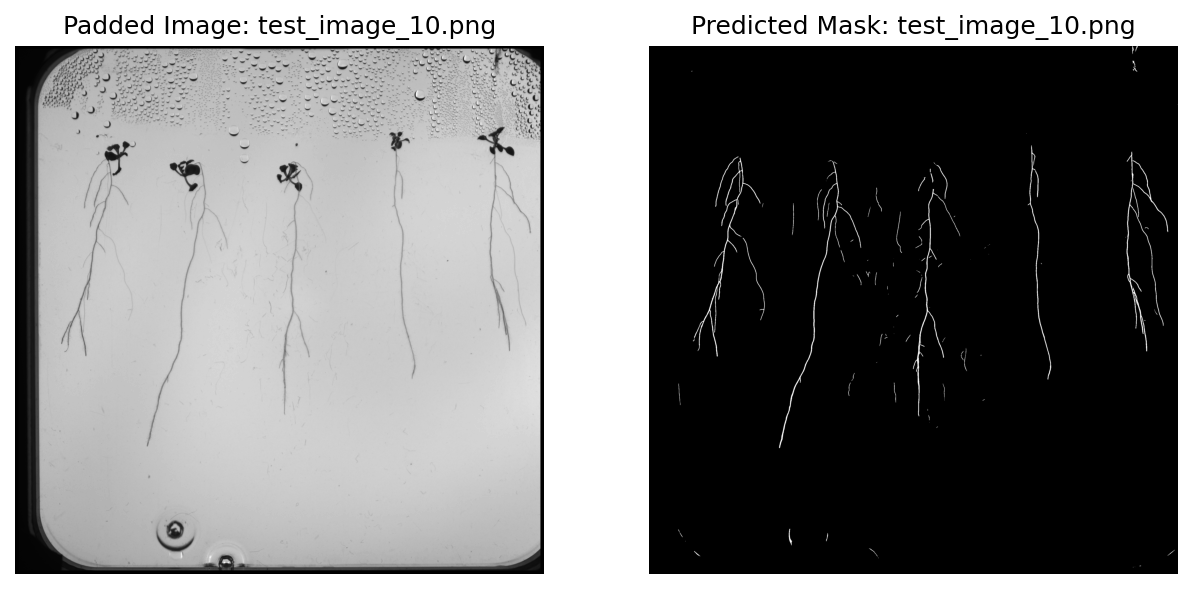

Processing test_image_11.png...
Completed test_image_11.png: Predicted Mask Shape = (2776, 2776)
Processing test_image_12.png...
Completed test_image_12.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_13.png...
Completed test_image_13.png: Predicted Mask Shape = (2927, 2927)
Processing test_image_14.png...
Completed test_image_14.png: Predicted Mask Shape = (2785, 2785)
Processing test_image_15.png...
Completed test_image_15.png: Predicted Mask Shape = (2787, 2787)
Processing test_image_16.png...
Completed test_image_16.png: Predicted Mask Shape = (2789, 2789)
Processing test_image_17.png...
Completed test_image_17.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_18.png...
Completed test_image_18.png: Predicted Mask Shape = (2788, 2788)
Processing test_image_2.png...
Completed test_image_2.png: Predicted Mask Shape = (2706, 2706)
Processing test_image_3.png...
Completed test_image_3.png: Predicted Mask Shape = (2706, 2706)
Processing test_image_4.png...
Com

In [53]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt
import os

def run_inference_on_padded_images(padded_images, model, patch_size, example_id=None):
    """
    Runs inference on multiple padded images, predicts masks, and crops them back to original dimensions.
    Visualizes results for a specified example image ID.

    Parameters:
        padded_images (dict): Dictionary containing padded images and their padding details.
        model (keras.Model): Pre-trained model for inference.
        patch_size (int): Size of patches for prediction.
        example_id (str): The exact ID of the image to visualize results for.

    Returns:
        dict: Dictionary with predicted masks and their original dimensions.
    """
    results = {}

    for file_name, data in padded_images.items():
        print(f"Processing {file_name}...")

        padded_image = data["padded_image"]
        padding = data["padding"]
        top_padding, bottom_padding, left_padding, right_padding = padding

        # Convert to 3 channels for patching
        padded_image_3channel = np.repeat(padded_image[..., np.newaxis], 3, axis=-1)

        # Create patches for prediction
        patches = patchify(padded_image_3channel, (patch_size, patch_size, 3), step=patch_size)
        patches_flat = patches.reshape(-1, patch_size, patch_size, 3) / 255.0  # Normalize

        # Predict patches
        predictions = model.predict(patches_flat, verbose=0)  # Run prediction silently
        predicted_patches = (predictions > 0.5).astype(np.uint8)
        predicted_patches_reshaped = predicted_patches.reshape(
            patches.shape[0], patches.shape[1], patch_size, patch_size
        )

        # Reconstruct the predicted mask
        predicted_mask = unpatchify(predicted_patches_reshaped, padded_image.shape[:2])

        # Remove padding
        predicted_mask_cropped = predicted_mask[
            top_padding:predicted_mask.shape[0] - bottom_padding,
            left_padding:predicted_mask.shape[1] - right_padding
        ]

        # Save the result
        results[file_name] = {
            "predicted_mask": predicted_mask_cropped,
            "original_shape": predicted_mask_cropped.shape
        }

        print(f"Completed {file_name}: Predicted Mask Shape = {predicted_mask_cropped.shape}")

        # Visualize only if the current file matches the exact example_id
        example_file_name = f"test_image_{example_id}.png"  # Adjust to match your naming convention
        if example_id and file_name == example_file_name:
            print(f"Visualizing example image: {file_name}")
            f, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
            ax[0].imshow(padded_image, cmap='gray')
            ax[0].axis('off')
            ax[0].set_title(f'Padded Image: {file_name}')
            ax[1].imshow(predicted_mask_cropped, cmap='gray')
            ax[1].axis('off')
            ax[1].set_title(f'Predicted Mask: {file_name}')
            plt.show()


    return results

# Run inference and visualize the specific example image
predicted_results = run_inference_on_padded_images(padded_images, model, patch_size, example_id)



### Reverse cropping:

In [89]:
def reverse_crop_shift_right_fixed(cropped_images, predicted_results, input_path, example_id=None, initial_crop=100):
    """
    Restores cropped masks to their original uncropped dimensions for all images by shifting the mask right
    while maintaining the original image size. Applies a fixed 100-pixel shift to the mask to the right.

    Parameters:
        cropped_images (dict): Dictionary containing cropped images and their crop slices.
        predicted_results (dict): Dictionary with predicted masks and their original dimensions.
        input_path (str): Path to the directory containing original images.
        example_id (str): The ID of the image to visualize the restored mask for.
        initial_crop (int): The number of pixels initially cropped from both the left and right sides.

    Returns:
        dict: Dictionary with restored masks for each image.
    """
    restored_masks = {}

    for file_name, data in predicted_results.items():
        # Load the original image to get its shape dynamically
        original_image_path = os.path.join(input_path, file_name)
        original_image = cv2.imread(original_image_path, 0)  # Load as grayscale
        original_shape = original_image.shape

        # Get crop slices and predicted mask
        crop_slices = cropped_images[file_name]["crop_slices"]
        predicted_mask = data["predicted_mask"]

        # Adjust the position of the mask by shifting it right by the initial crop value
        top, bottom = crop_slices[0].start, crop_slices[0].stop
        left, right = crop_slices[1].start + initial_crop, crop_slices[1].stop + initial_crop

        # Ensure that the mask is within the bounds of the original image
        left = max(left, 0)
        right = min(right, original_shape[1])

        # Restore the mask to original dimensions
        restored_image = np.zeros(original_shape, dtype=predicted_mask.dtype)
        restored_image[top:bottom, left:right] = predicted_mask

        # Now, shift the mask right by 100 pixels (hardcoded shift)
        shifted_restored_image = np.zeros_like(restored_image)
        shifted_restored_image[:, :-100] = restored_image[:, 100:]  # Shift right by 100 pixels

        # Save the restored mask
        restored_masks[file_name] = shifted_restored_image

        # Visualize only the example image
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing Restored Mask for: {file_name}")
            plt.figure(figsize=(5, 5))
            plt.imshow(shifted_restored_image, cmap='gray')
            plt.axis('off')
            plt.title(f"Restored and Shifted Mask: {file_name}")
            plt.show()

    return restored_masks


Visualizing Restored Mask for: test_image_2.png


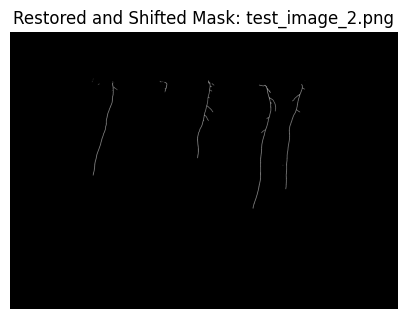

In [90]:
# Restore masks dynamically
restored_masks = reverse_crop_shift_right_fixed(
    cropped_images=cropped_images,
    predicted_results=predicted_results,
    input_path=input_path,
    example_id=example_id,
    initial_crop=100  # Match the initial cropping value
)


##### Overlay for verification:

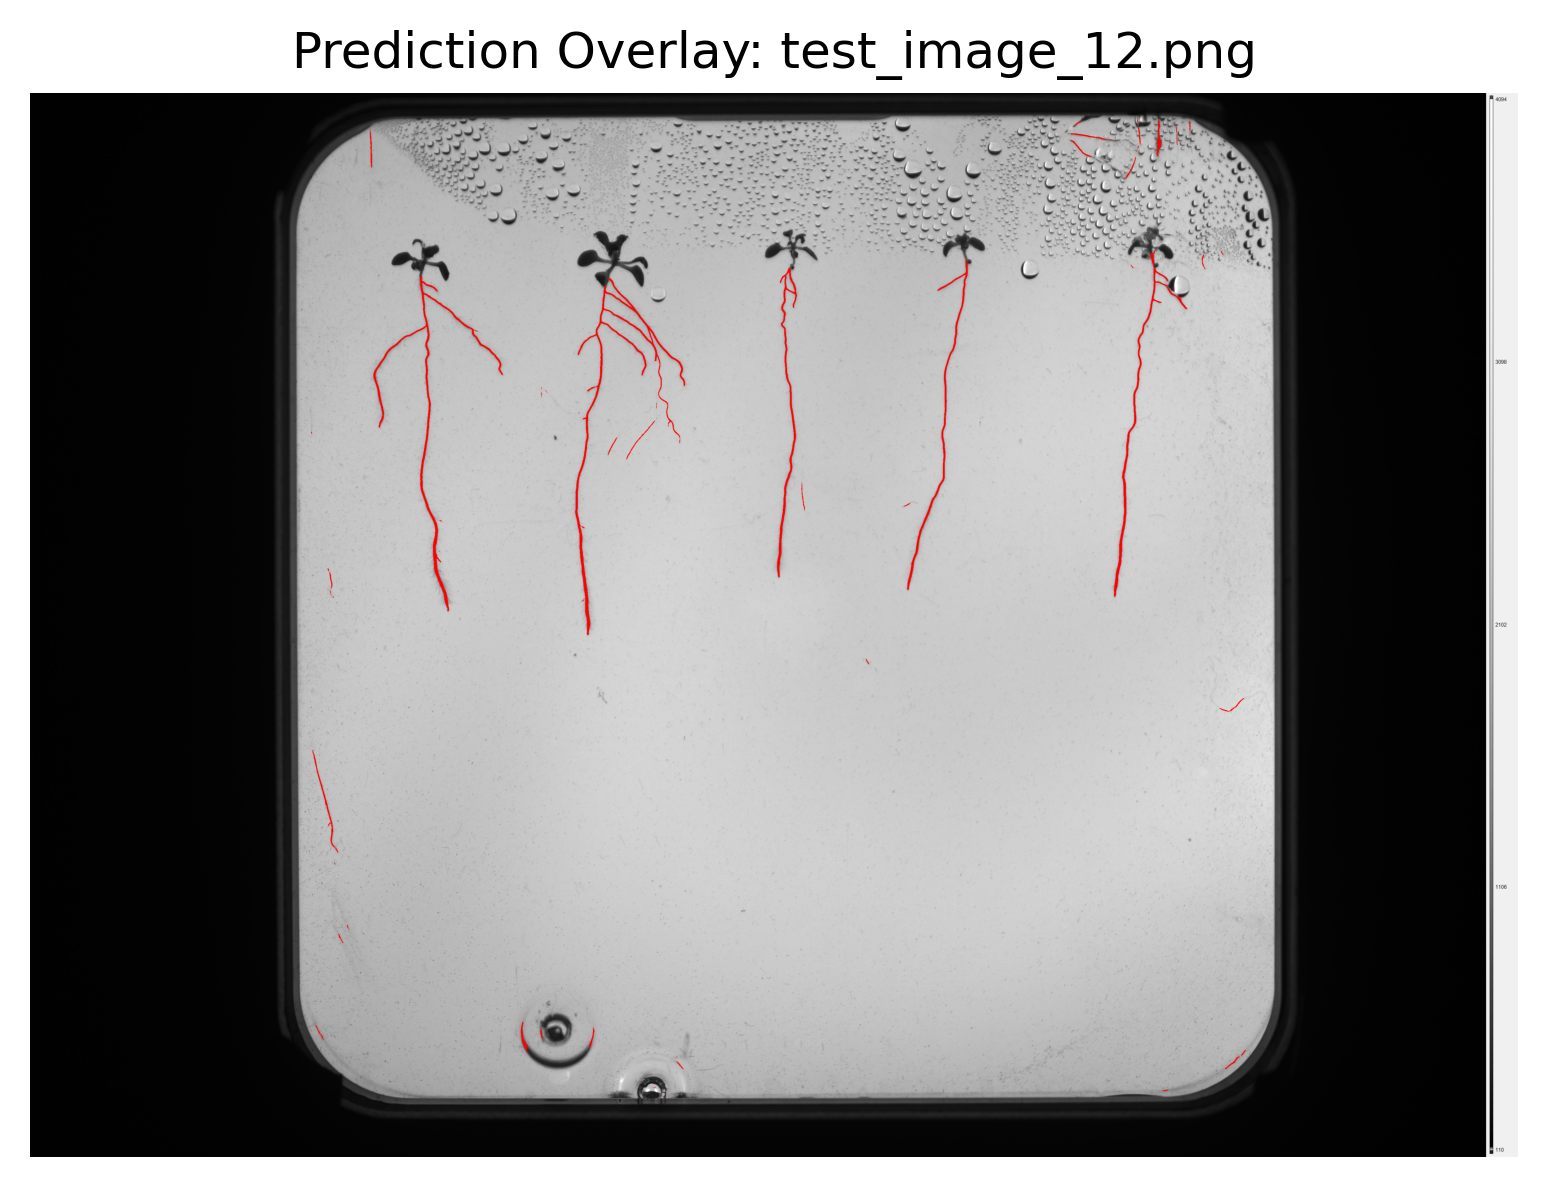

In [95]:
def overlay_restored_image(input_path, restored_masks, example_id=None):
    """
    Creates and visualizes an overlay of the predicted mask on the original uncropped image
    for a specific example ID by accessing images from the input path.

    Parameters:
        input_path (str): Path to the directory containing original images.
        restored_masks (dict): Dictionary containing restored masks.
        example_id (str): ID of the image to visualize the overlay for.

    Returns:
        None
    """
    for file_name, restored_mask in restored_masks.items():
        # Ensure the file matches the example ID
        if example_id and file_name != f"test_image_{example_id}.png":
            continue

        # Load the original image from the input path
        original_image_path = os.path.join(input_path, file_name)
        original_image = cv2.imread(original_image_path, 0)  # Load as grayscale

        # Ensure the restored mask matches the original image dimensions
        assert restored_mask.shape[:2] == original_image.shape[:2], \
            f"Shapes of mask ({restored_mask.shape[:2]}) and image ({original_image.shape[:2]}) do not match!"

        # Convert original image to RGB if it's grayscale
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)

        # Create the overlay
        overlay_image = original_image_rgb.copy()
        overlay_image[restored_mask > 0] = [255, 0, 0]  # Red overlay for mask (root pixels)

        # Plot the overlay
        plt.figure(dpi=300)
        plt.imshow(overlay_image)
        plt.axis('off')
        plt.title(f"Prediction Overlay: {file_name}")
        plt.show()
        break  # Visualize only the first matching image

# Visualize the overlay for the example ID
overlay_restored_image(input_path, restored_masks, example_id)


### Morphological operations:

Visualizing mask for test_image_12.png


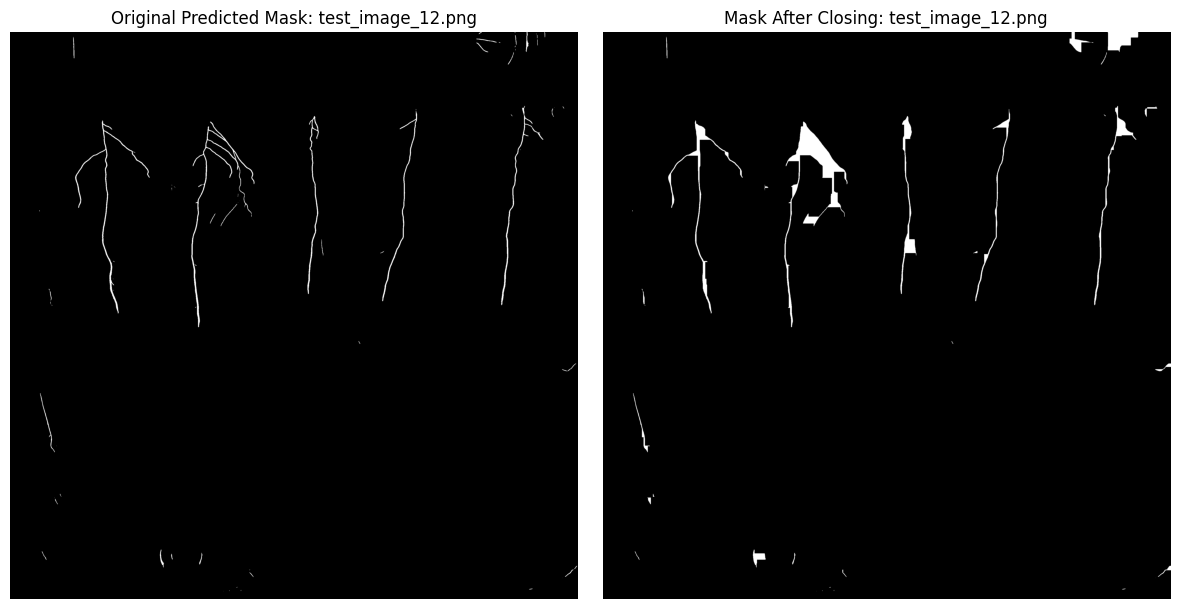

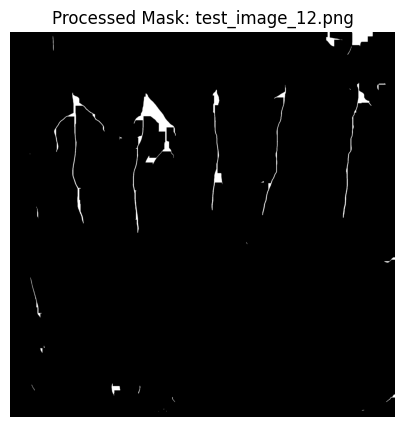

In [99]:
def apply_closing_only(mask, kernel_size):
    """
    Apply only closing to fill gaps without removing thin structures.
    
    Parameters:
        mask (numpy.ndarray): Input binary mask.
        kernel_size (tuple): Size of the structuring element for morphological operations.
    
    Returns:
        numpy.ndarray: Closed binary mask.
    """
    # Ensure the mask is binary (0 or 255) and 2D
    mask = (mask > 0).astype(np.uint8)  # Ensure binary format
    
    # Check that the mask is 2D
    if len(mask.shape) != 2:
        raise ValueError("The mask must be a 2D array.")

    # Create a structuring element
    kernel = np.ones(kernel_size, np.uint8)
    
    # Perform closing (dilation followed by erosion) to fill gaps
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask


def process_and_store_masks(predicted_masks, kernel_size=(51, 51), example_id=None):
    """
    Process the predicted masks by applying morphological closing and storing them for further use.
    Visualizes only the mask corresponding to the given example_id.
    
    Parameters:
        predicted_masks (dict): Dictionary of predicted masks.
        kernel_size (tuple): Size of the structuring element for morphological operations.
        example_id (str): The ID of the image to visualize (only visualizes the matching mask).
        
    Returns:
        dict: Dictionary of processed masks (closed masks).
    """
    processed_masks = {}

    for file_name, data in predicted_masks.items():
        # Access the predicted mask from the dictionary
        mask = data["predicted_mask"]  # This is the actual mask we want to process

        # Apply closing on each mask
        closed_mask = apply_closing_only(mask, kernel_size)
        processed_masks[file_name] = closed_mask
        
        # Visualize only the mask for the specified example_id
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing mask for {file_name}")
            
            plt.figure(figsize=(12, 6))

            # Original mask
            plt.subplot(1, 2, 1)
            plt.title(f"Original Predicted Mask: {file_name}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            # Closed mask
            plt.subplot(1, 2, 2)
            plt.title(f"Mask After Closing: {file_name}")
            plt.imshow(closed_mask, cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
    
    return processed_masks

# Assuming 'predicted_results' is defined as before
processed_masks = process_and_store_masks(predicted_results, example_id=example_id)

# Visualize the processed mask for the specific example_id
for file_name, mask in processed_masks.items():
    if file_name == f"test_image_{example_id}.png":
        plt.figure(figsize=(5, 5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"Processed Mask: {file_name}")
        plt.axis('off')
        plt.show()
        break  # Visualize only the first matching mask


Visualizing mask for test_image_10.png


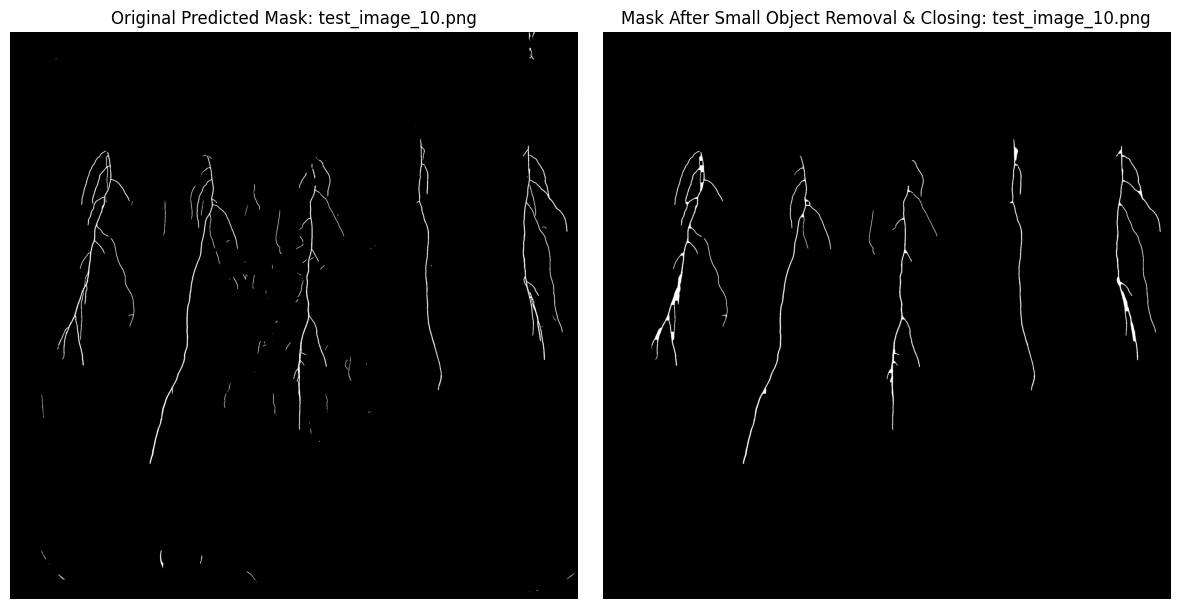

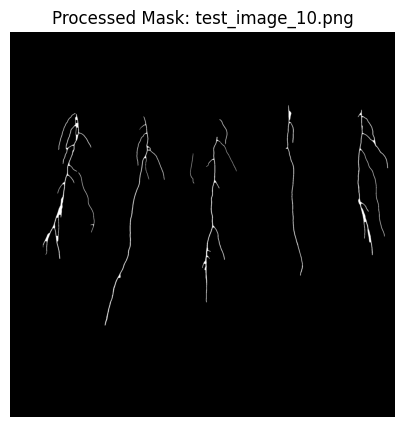

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
import cv2

# Step 1: Define Morphological Operations
def apply_closing_only(mask, kernel_size):
    """
    Apply only closing to fill gaps without removing thin structures.
    
    Parameters:
        mask (numpy.ndarray): Input binary mask.
        kernel_size (tuple): Size of the structuring element for morphological operations.
    
    Returns:
        numpy.ndarray: Closed binary mask.
    """
    # Ensure the mask is binary (0 or 255) and 2D
    mask = (mask > 0).astype(np.uint8)  # Ensure binary format
    
    # Check that the mask is 2D
    if len(mask.shape) != 2:
        raise ValueError("The mask must be a 2D array.")

    # Create a structuring element
    kernel = np.ones(kernel_size, np.uint8)
    
    # Perform closing (dilation followed by erosion) to fill gaps
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask

# Step 2: Function to remove small objects and apply closing
def remove_small_objects_and_apply_closing(mask, size_threshold, kernel_size):
    """
    Remove small objects and apply closing to the mask.
    
    Parameters:
        mask (numpy.ndarray): The input binary mask.
        size_threshold (int): Minimum size of objects to keep.
        kernel_size (tuple): Size of the structuring element for morphological operations.
    
    Returns:
        numpy.ndarray: The processed mask after small object removal and closing.
    """
    # Remove small objects based on size threshold
    mask_no_small_objects = morphology.remove_small_objects(mask > 0, min_size=size_threshold).astype('uint8') * 255
    
    # Apply morphological closing
    closed_mask = apply_closing_only(mask_no_small_objects, kernel_size)
    
    return closed_mask


# Step 3: Process the predicted masks and apply morphological operations
def process_and_store_masks(predicted_masks, size_threshold=600, kernel_size=(51, 51), example_id=None):
    """
    Process the predicted masks by removing small objects and applying morphological closing, then storing them for further use.
    Visualizes only the mask corresponding to the given example_id.
    
    Parameters:
        predicted_masks (dict): Dictionary of predicted masks.
        size_threshold (int): Minimum size of components to keep.
        kernel_size (tuple): Size of the structuring element for morphological operations.
        example_id (str): The ID of the image to visualize (only visualizes the matching mask).
        
    Returns:
        dict: Dictionary of processed masks (closed masks).
    """
    processed_masks = {}

    for file_name, data in predicted_masks.items():
        # Access the predicted mask from the dictionary
        mask = data["predicted_mask"]  # This is the actual mask we want to process

        # Remove small objects and apply closing
        closed_mask = remove_small_objects_and_apply_closing(mask, size_threshold, kernel_size)
        
        # Store the processed mask in the dictionary
        processed_masks[file_name] = closed_mask
        
        # Visualize only the mask for the specified example_id
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing mask for {file_name}")
            
            plt.figure(figsize=(12, 6))

            # Original mask
            plt.subplot(1, 2, 1)
            plt.title(f"Original Predicted Mask: {file_name}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            # Processed mask
            plt.subplot(1, 2, 2)
            plt.title(f"Mask After Small Object Removal & Closing: {file_name}")
            plt.imshow(closed_mask, cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return processed_masks

example_id = "10"

# Example of calling the function
processed_masks = process_and_store_masks(predicted_results, size_threshold=600, kernel_size=(12, 12), example_id=example_id)

# Visualize the processed mask for the specific example_id
for file_name, mask in processed_masks.items():
    if file_name == f"test_image_{example_id}.png":
        plt.figure(figsize=(5, 5))
        plt.imshow(mask, cmap='gray')
        plt.title(f"Processed Mask: {file_name}")
        plt.axis('off')
        plt.show()
        break  # Visualize only the first matching mask


### Creating bounding boxes:

Visualizing bounding boxes for test_image_10.png


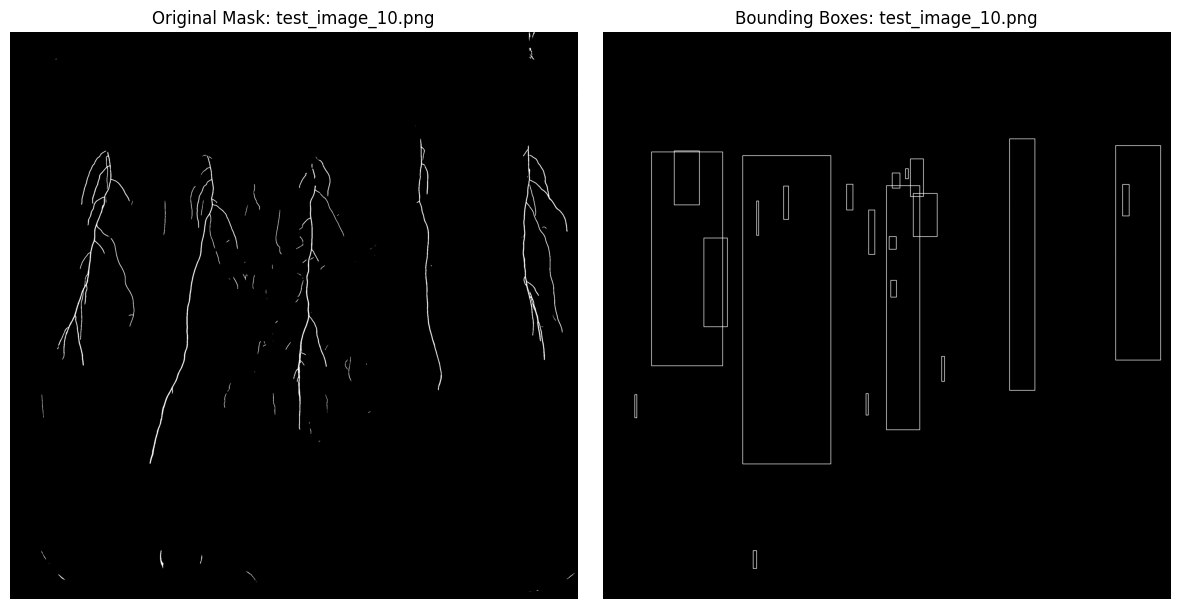

Bounding boxes for test_image_10.png: [(1988, 527, 2112, 1757), (2507, 560, 2727, 1609), (348, 586, 471, 850), (237, 591, 585, 1637), (683, 609, 1114, 2117), (1503, 625, 1567, 809), (1479, 673, 1493, 722), (1414, 694, 1452, 768), (1191, 749, 1222, 875), (2541, 750, 2573, 904), (1386, 756, 1549, 1950), (883, 758, 907, 921), (1517, 794, 1634, 1005), (751, 831, 761, 999), (1299, 875, 1329, 1092), (1399, 1005, 1434, 1067), (493, 1012, 608, 1446), (1407, 1219, 1435, 1301), (1656, 1591, 1670, 1713), (1286, 1773, 1297, 1878), (155, 1778, 165, 1891), (734, 2541, 751, 2628)]


In [131]:
def extract_bounding_boxes_from_stats(stats, min_area=200):
    """
    Extract bounding boxes from connected component stats, ensuring the bounding boxes correspond to
    valid connected components based on area size.

    Parameters:
        stats (np.ndarray): Statistics from connected components (x, y, width, height, area).
        min_area (int): Minimum area threshold for valid bounding boxes.
    
    Returns:
        list: List of bounding boxes [(x_min, y_min, x_max, y_max), ...].
    """
    bounding_boxes = []
    
    for stat in stats[1:]:  # Skip the background (index 0)
        x, y, w, h, area = stat
        if area >= min_area:
            bounding_boxes.append((x, y, x + w, y + h))
    
    return bounding_boxes


def process_and_extract_bounding_boxes(predicted_masks, min_area=200, example_id=None):
    """
    Processes the predicted masks, extracts bounding boxes, and visualizes results for the example_id.
    
    Parameters:
        predicted_masks (dict): Dictionary of predicted masks.
        min_area (int): Minimum area threshold for bounding boxes.
        example_id (str): ID of the image to visualize bounding boxes.
        
    Returns:
        dict: Dictionary containing the bounding boxes for each processed mask.
    """
    bounding_boxes_results = {}

    for file_name, data in predicted_masks.items():
        mask = data["predicted_mask"]

        # Find connected components in the mask
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

        # Extract bounding boxes from the stats
        bounding_boxes = extract_bounding_boxes_from_stats(stats, min_area)

        bounding_boxes_results[file_name] = bounding_boxes

        # Visualize bounding boxes on the mask for the specified example_id
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing bounding boxes for {file_name}")

            # Plot the original mask
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title(f"Original Mask: {file_name}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            # Draw the bounding boxes
            overlay_image = mask.copy()
            for bbox in bounding_boxes:
                x_min, y_min, x_max, y_max = bbox
                cv2.rectangle(overlay_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Red bounding box

            plt.subplot(1, 2, 2)
            plt.title(f"Bounding Boxes: {file_name}")
            plt.imshow(overlay_image, cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return bounding_boxes_results

# Example of calling the function
bounding_boxes_results = process_and_extract_bounding_boxes(predicted_results, min_area=200, example_id=example_id)

# Visualize bounding boxes for the specified example_id
for file_name, bounding_boxes in bounding_boxes_results.items():
    if file_name == f"test_image_{example_id}.png":
        print(f"Bounding boxes for {file_name}: {bounding_boxes}")
        break  # Visualize only the first matching image


### Filtering out overlapping boxes:

Visualizing processed mask for: test_image_10.png


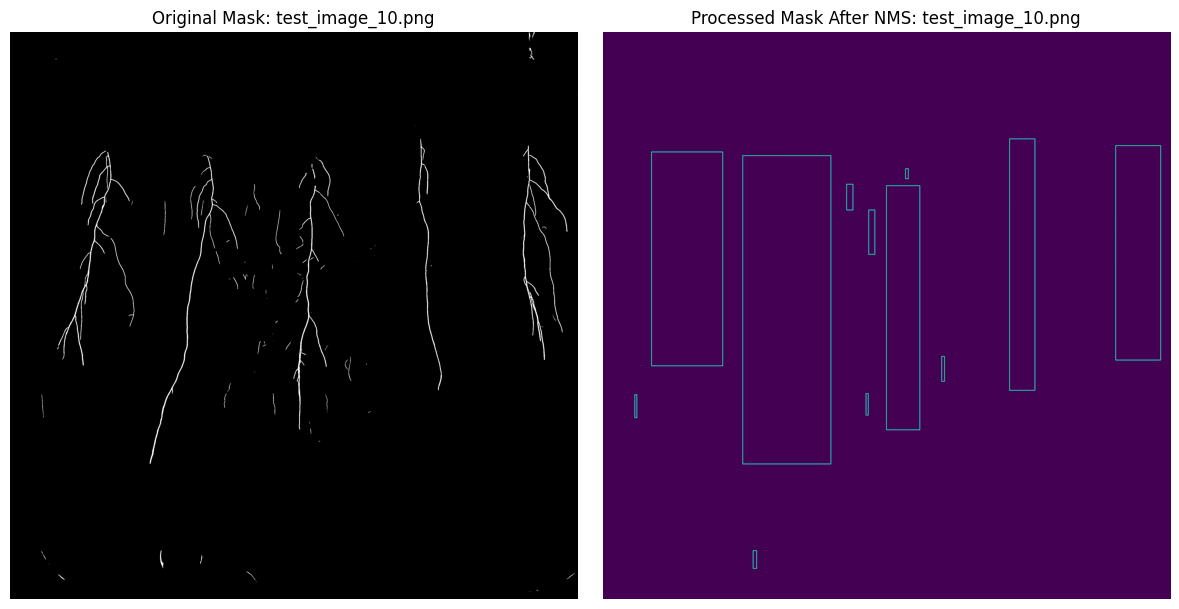

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology

# Function to apply Non-Maximum Suppression (NMS)
def non_maximum_suppression(bboxes, iou_threshold=0.01):
    """
    Apply Non-Maximum Suppression (NMS) to remove overlapping bounding boxes.
    
    Parameters:
        bboxes (list): List of bounding boxes [(x_min, y_min, x_max, y_max)].
        iou_threshold (float): Threshold for IoU to consider boxes as overlapping.
    
    Returns:
        list: Filtered list of bounding boxes after NMS.
    """
    if len(bboxes) == 0:
        return []
    
    # Convert bounding boxes to numpy array
    bboxes = np.array(bboxes)
    
    # Compute areas of each bounding box
    areas = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    
    # Sort bounding boxes by area (descending order)
    sorted_indices = np.argsort(areas)[::-1]
    bboxes = bboxes[sorted_indices]
    
    # List to hold filtered boxes
    filtered_bboxes = []
    
    while len(bboxes) > 0:
        # Take the largest box and add it to the result
        current_box = bboxes[0]
        filtered_bboxes.append(current_box)
        bboxes = bboxes[1:]  # Remove the current box
        
        # Compute IoU with remaining boxes
        to_keep = []
        for box in bboxes:
            # Calculate intersection
            x_min = max(current_box[0], box[0])
            y_min = max(current_box[1], box[1])
            x_max = min(current_box[2], box[2])
            y_max = min(current_box[3], box[3])
            inter_area = max(0, x_max - x_min) * max(0, y_max - y_min)
            
            # Calculate union
            union_area = (
                areas[np.argmax(areas)] +
                (box[2] - box[0]) * (box[3] - box[1]) - inter_area
            )
            
            # Calculate IoU
            iou = inter_area / union_area
            
            # Keep the box if IoU is below the threshold
            if iou <= iou_threshold:
                to_keep.append(box)
        
        bboxes = np.array(to_keep)  # Update remaining boxes
    
    return filtered_bboxes


# Extract bounding boxes from connected components
def extract_bounding_boxes_from_stats(stats, min_area=200):
    """
    Extract bounding boxes from connected component stats.
    
    Parameters:
        stats (np.ndarray): Statistics from connected components (x, y, width, height, area).
        min_area (int): Minimum area threshold for valid bounding boxes.
    
    Returns:
        list: List of bounding boxes [(x_min, y_min, x_max, y_max), ...].
    """
    bounding_boxes = []
    
    for stat in stats[1:]:  # Skip the background (index 0)
        x, y, w, h, area = stat
        if area >= min_area:
            bounding_boxes.append((x, y, x + w, y + h))
    
    return bounding_boxes


# Function to process masks, apply NMS, and visualize
def process_and_apply_nms_to_masks(predicted_masks, min_area=200, iou_threshold=0.01, example_id=None):
    """
    Process the predicted masks, apply NMS, and visualize only the specified example_id.
    
    Parameters:
        predicted_masks (dict): Dictionary of predicted masks.
        min_area (int): Minimum area for bounding box extraction.
        iou_threshold (float): Threshold for Non-Maximum Suppression.
        example_id (str): ID of the image to visualize.
    
    Returns:
        dict: Dictionary of processed masks with bounding boxes.
    """
    processed_masks = {}

    for file_name, mask_data in predicted_masks.items():
        mask = mask_data["predicted_mask"]

        # Find connected components in the mask
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

        # Extract bounding boxes
        bounding_boxes = extract_bounding_boxes_from_stats(stats, min_area)

        # Apply Non-Maximum Suppression (NMS)
        filtered_bboxes = non_maximum_suppression(bounding_boxes, iou_threshold)

        # Draw bounding boxes on the mask
        mask_with_bboxes_nms = mask.copy()
        for bbox in filtered_bboxes:
            x_min, y_min, x_max, y_max = bbox
            cv2.rectangle(mask_with_bboxes_nms, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Red bounding box

        # Save the processed mask
        processed_masks[file_name] = {
            "processed_mask": mask_with_bboxes_nms,
            "filtered_bboxes": filtered_bboxes
        }

        # Visualize only the example image if `example_id` matches
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing processed mask for: {file_name}")
            
            plt.figure(figsize=(12, 6))

            # Original mask
            plt.subplot(1, 2, 1)
            plt.title(f"Original Mask: {file_name}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            # Processed mask with NMS bounding boxes
            plt.subplot(1, 2, 2)
            plt.title(f"Processed Mask After NMS: {file_name}")
            plt.imshow(mask_with_bboxes_nms)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return processed_masks



processed_masks = process_and_apply_nms_to_masks(predicted_results, min_area=200, iou_threshold=0.0001, example_id=example_id)


### Creating the Connected Components based on the bounding boxes:

Visualizing processed mask for: test_image_10.png


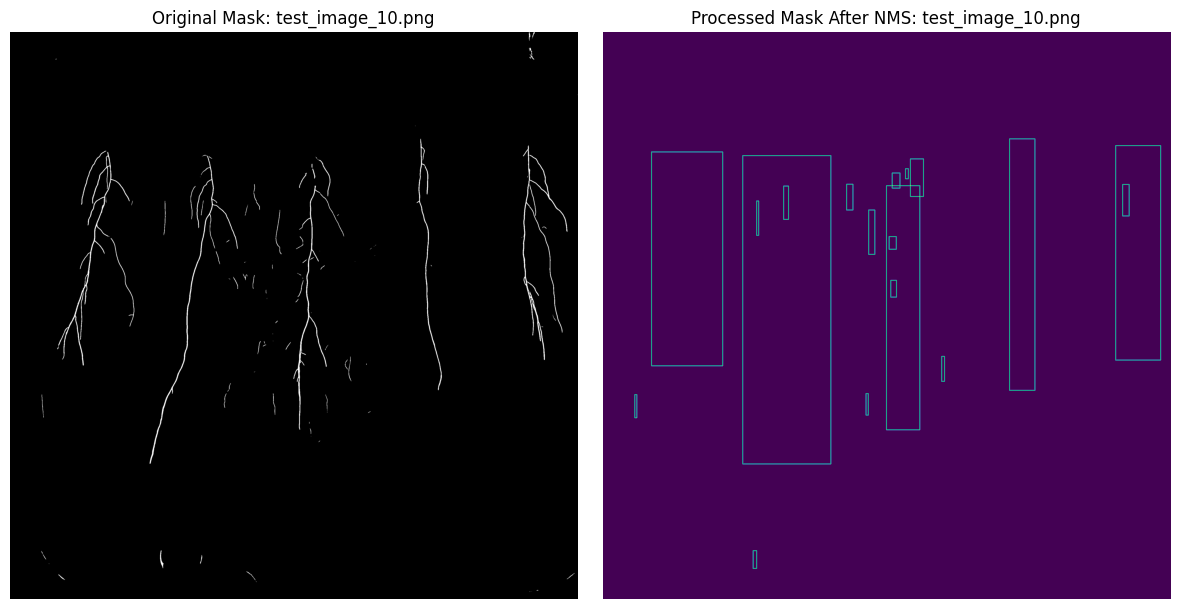

Visualizing labeled mask for test_image_10.png


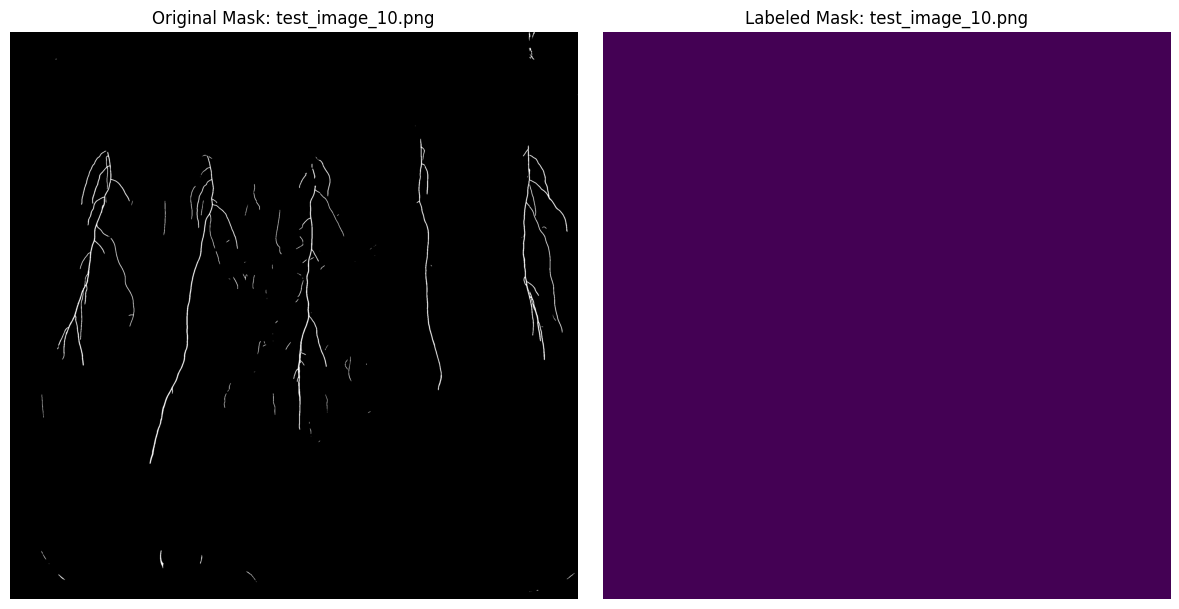

Bounding boxes for test_image_10.png:


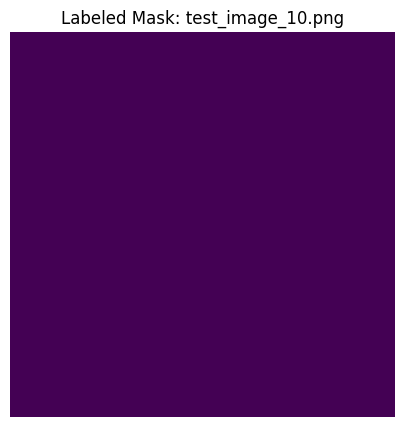

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
import cv2

def create_single_component_labeled_mask_for_all(predicted_masks, bounding_boxes_dict, example_id=None):
    """
    Process each predicted mask in the dictionary and assign each bounding box one connected component.
    
    Parameters:
        predicted_masks (dict): Dictionary containing predicted masks for each image.
        bounding_boxes_dict (dict): Dictionary containing bounding boxes for each image.
        example_id (str): The ID of the image to visualize.
    
    Returns:
        dict: Dictionary of labeled masks for each image.
    """
    labeled_masks = {}  # Dictionary to store labeled masks for each image

    for file_name, mask_data in predicted_masks.items():
        mask = mask_data["predicted_mask"]
        
        # Get bounding boxes for the current mask
        bounding_boxes = bounding_boxes_dict.get(file_name, [])

        # Check if bounding_boxes is empty
        if not bounding_boxes:
            continue

        # Initialize a blank labeled mask with the same shape as the original mask
        labeled_mask = np.zeros_like(mask, dtype=np.uint16)

        # Iterate through each bounding box
        for label_id, bbox in enumerate(bounding_boxes, start=1):  # Start labels from 1
            if len(bbox) == 4:  # Ensure correct bounding box format (x_min, y_min, x_max, y_max)
                x_min, y_min, x_max, y_max = bbox

                # Crop the region of the root from the original mask
                root_region = mask[y_min:y_max, x_min:x_max]

                # Label connected components within this region
                labeled_components, num_components = label(root_region > 0)

                if num_components > 0:
                    # Find the largest connected component within the bounding box
                    component_sizes = [(labeled_components == i).sum() for i in range(1, num_components + 1)]
                    largest_component_idx = component_sizes.index(max(component_sizes)) + 1  # 1-based index

                    # Extract the largest component and assign its label
                    largest_component = (labeled_components == largest_component_idx)
                    labeled_mask[y_min:y_max, x_min:x_max][largest_component] = label_id

        # Store the labeled mask for the current image
        labeled_masks[file_name] = labeled_mask

        # Visualize the result for the specified example_id
        if example_id and file_name == f"test_image_{example_id}.png":
            print(f"Visualizing labeled mask for {file_name}")
            
            plt.figure(figsize=(12, 6))
            
            # Original mask
            plt.subplot(1, 2, 1)
            plt.title(f"Original Mask: {file_name}")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            # Labeled mask
            plt.subplot(1, 2, 2)
            plt.title(f"Labeled Mask: {file_name}")
            plt.imshow(labeled_mask, cmap='viridis')  # Use a colormap for better visualization
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    return labeled_masks

example_id = "10"

# Example of calling the function with predicted results and bounding boxes dictionary
bounding_boxes_dict = process_and_apply_nms_to_masks(predicted_results, min_area=200, iou_threshold=0.01, example_id=example_id)

# Process the masks and get labeled masks
labeled_masks = create_single_component_labeled_mask_for_all(predicted_results, bounding_boxes_dict, example_id=example_id)

# Visualize the labeled mask for the specific example_id
for file_name, labeled_mask in labeled_masks.items():
    if file_name == f"test_image_{example_id}.png":
        print(f"Bounding boxes for {file_name}:")
        plt.figure(figsize=(5, 5))
        plt.imshow(labeled_mask, cmap='viridis')
        plt.title(f"Labeled Mask: {file_name}")
        plt.axis('off')
        plt.show()
        break  # Visualize only the first matching mask
